<a href="https://colab.research.google.com/github/danihga/Jovia/blob/main/CatholicHealth_Unbalanced_DTrees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Dealing with Unbalanced Classes](https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/)

Tomek links are pairs of very close instances but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


# Data Preprocessing
Data Split, Train-test Split, etc...

In [ ]:
#Import Data

data = pd.read_excel(r'/content/DeidentifiedSDOHPatientData-v1.xlsx')

data.sample(6)

data.columns = ['id', 'age', 'race', 'ethnicity', 'gender',
       'food would run out',
       'Food didn’t last and no money for more',
       'Lack transportation kept from medical appointments or medications?',
       'Lack transportation kept from meetings, work, or things needed for daily living?',
       'Not able to pay the mortgage or rent on time?',
       'Not have a steady place to sleep or slept in a shelter?',
       'Electric, gas, oil, or water company threatened to shut off services?',
       'Fearful of physical/emotional abuse from relative?']

# Only get the first three columns - predictor, and only question column - label
data = data[['age', 'race', 'ethnicity', 'gender',
       'food would run out']]

# Drop NAs

#data = data.dropna()

**Targe - Feature Split**

In [ ]:
# Drop Patient declined, Patient unable to answer
target_rows     = (data['food would run out']=='Patient declined')| (data['food would run out']=='Patient unable to answer') | (data['food would run out'].isnull())

future_predict  = data[target_rows]

future_predict.drop(columns = ['food would run out'])

tree_data       = data[~target_rows]

In [ ]:
X = tree_data.drop(columns = 'food would run out')
y = tree_data['food would run out']

**Label Encoding**


```
{'Never True':0, 'Sometimes True':1, 'Often True':1}
```



In [ ]:
mapping = {'Never True':0,
       'Sometimes True':1, 'Often True':1}

reverse_mapping = {0:'Patient unable to answer', 1:'Patient declined', 2:'Never True',3:'Sometimes True', 4:'Often True'}

y = y.map(mapping)

In [ ]:
from sklearn.preprocessing import StandardScaler

categorical_columns = X[['race', 'ethnicity']]

# One-hot encoding for the categorical columns
encoder = OneHotEncoder(sparse_output = False)
categorical_encoded = encoder.fit_transform(categorical_columns)

col_one_hot = list(encoder.get_feature_names_out())
# Convert the one-hot encoded array into a DataFrame with the created column names
one_hot_df = pd.DataFrame(categorical_encoded, columns=col_one_hot)

scaled_age = (X['age']-X['age'].mean())/X['age'].std()

one_hot_df['age'] =list(scaled_age)
X = one_hot_df.copy()

In [ ]:
from sklearn.model_selection import train_test_split

# Data Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = 0, stratify=y)

# Functions

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
import sklearn
# define model
def do_grid(X_train, y_train, metric):
  model = DecisionTreeClassifier()

  # define grid
  param_grid = {
      'class_weight': [None, 'balanced',{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}],
      'max_depth': [None, 3, 6, 10, 20, 30],
      #'min_samples_split': [2, 5, 10],
      'min_samples_leaf': [1, 2, 4]
  }

  # define evaluation procedure
  cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

  # define grid search
  grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring=metric)

  # execute the grid search
  grid_result = grid.fit(X_train, y_train)

  # report the best configuration
  print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

  # report all configurations
  '''
  means = grid_result.cv_results_['mean_test_score']
  stds = grid_result.cv_results_['std_test_score']
  params = grid_result.cv_results_['params']
  for mean, stdev, param in zip(means, stds, params):
      print("%f (%f) with: %r" % (mean, stdev, param))'''

In [ ]:
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
def dt(X_train, y_train, X_test, y_test, weights={0: 100, 1: 1},max_depth=3, min_samples_leaf=4):
  model1 = DecisionTreeClassifier(class_weight=weights,
                                  max_depth=max_depth,
                                  min_samples_leaf=min_samples_leaf
                                  #min_samples_split=2
                                  ).fit(X_train,y_train)
  #'class_weight': {0: 100, 1: 1}, 'max_depth': None, 'min_samples_leaf': 4
  # Make predictions on the testing data
  y_train_pred = model1.predict(X_train)
  y_test_pred = model1.predict(X_test)

  print(accuracy_score(y_train, y_train_pred))
  print(accuracy_score(y_test, y_test_pred))
  print(classification_report(y_test, y_test_pred))
  cm = confusion_matrix(y_test, y_test_pred)
  dist= ConfusionMatrixDisplay(cm, display_labels=model1.classes_)
  dist.plot()

# Try Different Sampling Techniques

**Smote**

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_smt_train, y_smt_train = oversample.fit_resample(X_train, y_train)

In [ ]:
from sklearn.metrics import make_scorer
from sklearn.metrics import make_scorer, precision_score, recall_score

def custom_scorer(y_true, y_pred):
    recall_label_0 = recall_score(y_true, y_pred, pos_label=0)
    recall_label_1 = recall_score(y_true, y_pred, pos_label=1)
    weighted_recall = 0.8 * recall_label_1 + 0.2 * recall_label_0  # Weighted average with more weight on label 1
    return weighted_recall
scorer = make_scorer(custom_scorer)

In [ ]:
do_grid(X_smt_train, y_smt_train, scorer)

Best: 0.952319 using {'class_weight': {0: 1, 1: 10}, 'max_depth': None, 'min_samples_leaf': 2}


0.5175122749590835
0.05054413542926239
              precision    recall  f1-score   support

           0       0.99      0.04      0.07      4074
           1       0.02      0.98      0.03        61

    accuracy                           0.05      4135
   macro avg       0.50      0.51      0.05      4135
weighted avg       0.98      0.05      0.07      4135



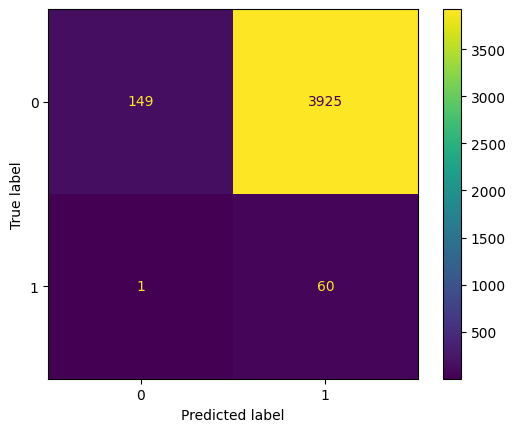

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

dt(X_smt_train, y_smt_train, X_test, y_test, weights={0: 1, 1: 100},max_depth=3, min_samples_leaf=1)

**Under-Sampling -- imblearn**

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
x_rus, y_rus = rus.fit_resample(X_train, y_train)

In [ ]:
do_grid(x_rus, y_rus, 'f1')

In [ ]:
dt(x_rus, y_rus, X_test, y_test,
   weights={0: 1, 1: 10},
   max_depth=3,
   min_samples_leaf=1)

In [ ]:
y_rus.value_counts()

**Nearmiss under-sampling**

In [ ]:
from imblearn.under_sampling import NearMiss

nm = NearMiss()

x_nm, y_nm = nm.fit_resample(X_train, y_train)

print('Original dataset shape:', y_train.value_counts())
print('Resample dataset shape:', y_nm.value_counts())

In [ ]:
do_grid(x_nm, y_nm, 'f1')

In [ ]:
dt(x_nm, y_nm, X_test, y_test, weights='balanced',max_depth=310, min_samples_leaf=2)